# Projeto 15 Geração de imagens

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import PIL
from tensorflow.keras import layers
from IPython import display
import tensorflow as tf
import pickle
import time

## importação e tratamento da base de dados

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [6]:
train_images.shape

(60000, 28, 28, 1)

In [7]:
#normalização

train_images = (train_images -127.5) / 127.5

In [8]:
buffer_size = 60000
batch_size = 256

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [10]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

### Construção do Gerador

In [11]:
def make_generator():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100, ))) # 12544
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 256)))
    
    #7x7x128
    model.add(layers.Convolution2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #14x14x64
    model.add(layers.Convolution2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #28, 28, 1
    model.add(layers.Convolution2DTranspose(1, (5,5), strides=(2,2), padding='same', 
                                            use_bias=False, activation='tanh'))
    
    model.summary()
    
    return model

In [12]:
noise = tf.random.normal([1, 100])
noise.shape

TensorShape([1, 100])

In [13]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.4356784 ,  1.0734032 , -0.31823984,  2.2940562 ,  0.6396277 ,
        -0.7618794 ,  0.17057806,  0.36000797,  0.85921824,  0.52133906,
        -0.49450153, -2.2327535 , -0.97321796,  2.302355  ,  0.4537355 ,
        -1.0872172 ,  0.29157925,  0.32130066, -0.16641372,  0.38585863,
        -1.428899  , -0.2688131 , -0.55741274, -2.4211612 , -0.13306059,
        -0.40824297,  2.0249374 ,  0.7112749 ,  1.0415161 ,  1.4448376 ,
        -0.54721975, -0.21250029,  1.6267625 , -1.6831043 ,  0.402821  ,
         0.47421136,  0.4863388 ,  0.40591413,  0.40366778, -1.0243658 ,
         0.07354546,  1.8920796 ,  0.38641974,  0.8044398 , -1.083878  ,
         1.3214535 ,  0.4703477 , -2.949638  , -0.49541554,  0.9782772 ,
         1.3640678 ,  0.7043544 , -1.2777969 ,  0.15232974, -0.83964264,
        -0.91113836,  2.4476252 ,  0.7905993 , -1.5094221 ,  0.67734367,
        -0.8412051 , -0.49926776, -1.6680443 , -1.3076415 , -0.19937502,
 

In [14]:
generator = make_generator()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [15]:
generate_image = generator(noise, training=False)

In [16]:
generate_image.shape

TensorShape([1, 28, 28, 1])

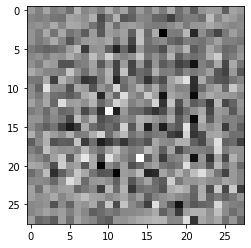

In [17]:
plt.imshow(generate_image[0, :, :, 0], cmap='gray')

### Construção do Discriminador

In [18]:
def make_discriminator_model ():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides = (2,2), padding='same', input_shape=([28, 28, 1])))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5,5), strides = (2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(1))
    
    model.summary()
    
    return model


In [19]:
discriminator = make_discriminator_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [20]:
decision = discriminator(generate_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00107432]], dtype=float32)>

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss (real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optmizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optmizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

checkpoint = tf.train.Checkpoint(generator_optmizer=generator_optmizer, 
                                 discriminator_optmizer=discriminator_optmizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Treinamento do Modelo

In [23]:
epochs = 10
noise_dim = 100
num_exemples_to_generate = 16


In [24]:
seed = tf.random.normal([num_exemples_to_generate, noise_dim])

In [25]:
seed.shape

TensorShape([16, 100])

In [26]:
@tf.function
def train_steps(images):
    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Chamando o gerador e passando os numeros aleatórios 
        generated_images = generator(noise, training=True)
        
        #passando as imagens fakes para o discriminador, para fazer a classificação
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        #Calculando a loss para o gerador e o discriminador
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    #Calcular o gradiente das losses para atualizar os pesos
    gradiente_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradiente_of_discriminator = disc_tape.gradient(disc_tape, discriminator.trainable_variables)
    
    #Aplicar otimizadores e ajustar os pesos
    generator_optmizer.apply_gradients(zip(gradiente_of_generator, generator.trainable_variables))
    discriminator_optmizer.apply_gradients(zip(gradiente_of_discriminator, discriminator.trainable_variables))

In [27]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [28]:
def train(dataset, epochs=10):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_steps(image_batch)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        print('Time for epoch {} is {} sec. '.format((epoch+1), (time.time() - start)))
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)


In [ ]:
train(train_dataset, epochs=30)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))